# RNN model

basic import

In [51]:
# Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from scipy.stats import reciprocal
import keras
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

from sklearn.model_selection import RandomizedSearchCV

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='dark')

train = pd.read_csv('train_2.csv', index_col=0)
print(f'{train.shape[0]} time series (rows): daily views of each web page')
print(f'{train.shape[1]} days (columns): from {train.columns.min()} to {train.columns.max()}')
train.head(1)

In C:\Users\elena\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\elena\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\elena\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\elena\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\elena\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

145063 time series (rows): daily views of each web page
803 days (columns): from 2015-07-01 to 2017-09-10


,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
Page,,,,,,,,,,,,,,,,,,,,,
2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0


## 1 Data Preprocessing
* en.wikipedia: more views (US-based site), large spikes in Aug 2016 (olympics) & Nov 2016 (election)
* es.wikipedia: weekly seasonality, 6-month dip

In [3]:
es = train.iloc[page_details[page_details['web'] == 'es.wikipedia'].index, :].sum()
es.index = pd.to_datetime(es.index)
es_dif = (es - es.shift(1)).iloc[1:,]

* ACF: large spikes every 7 days due to weekly seasonality
* PACF: the first week has the largest spike

* es.wikipedia (all-agents vs spider): spider is approximately constant
* es.wikipedia (all-access vs desktop vs mobile-web): three groups have similar trends

## 2 Feature Engineering
* missing values

9.3% web pages (329 out of 3537) have one or more missing value


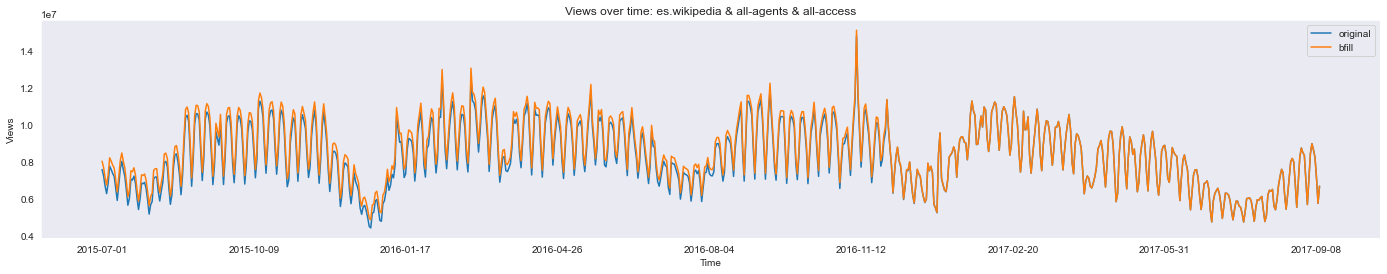

In [9]:
df = (page_details['access'] == 'all-access') & (page_details['agent'] == 'all-agents') & (page_details['web'] == 'es.wikipedia')
df = train.iloc[df[df].index,:]

na_num = sum(df.isna().sum(axis=1) != 0)
num = df.shape[0]
print(f'{round(na_num/num*100, 1)}% web pages ({na_num} out of {num}) have one or more missing value')

original = df.sum()
bfill = df.T.fillna(method='bfill').T.sum()
original.plot(figsize=(24,4), title='Views over time: es.wikipedia & all-agents & all-access', ylabel='Views', xlabel='Time', label='original')
bfill.plot(label='bfill')
plt.legend()

In [10]:
df = bfill.to_frame('Views').reset_index().rename(columns={'index': 'Date'})
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Views
0,2015-07-01,8022174.0
1,2015-07-02,7687790.0
2,2015-07-03,7121842.0
3,2015-07-04,6720181.0
4,2015-07-05,7275102.0
...,...,...
798,2017-09-06,8638762.0
799,2017-09-07,8234557.0
800,2017-09-08,7135816.0
801,2017-09-09,5737143.0


In [12]:
df.rename(columns={"Views":"X"}, inplace = True)

In [14]:
df['y'] = df['X'].shift(-5)
df = df.dropna()

In [15]:
df

,Date,X,y
0,2015-07-01,8022174.0,8207923.0
1,2015-07-02,7687790.0,8023348.0
2,2015-07-03,7121842.0,7806737.0
3,2015-07-04,6720181.0,7648772.0
4,2015-07-05,7275102.0,7001292.0
...,...,...,...
793,2017-09-01,6972357.0,8638762.0
794,2017-09-02,5673588.0,8234557.0
795,2017-09-03,7012175.0,7135816.0
796,2017-09-04,8435963.0,5737143.0


## 3 RNN model

In [17]:
X = df[['X']]
y = df[['y']]

In [18]:
X_train, y_train, X_test, y_test = X[:-60], y[:-60], X[-60:], y[-60:]

### 3.1 feature scaling

In [19]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = np.reshape(X_train,(-1,1))
y_train = np.reshape(y_train,(-1,1))
print(X_train.shape, y_train.shape)

X_train = sc.fit_transform(X_train)
y_train = sc.fit_transform(y_train)

(738, 1) (738, 1)


### 3.2 RNN model comparison

#### 3.2.1 simple LSTM model

In [22]:
#Training LSTM
#Reshaping Array
X_train = np.reshape(X_train, (738,1,1))

# Initialising the RNN
model = Sequential()

# Adding the input layerand the LSTM layer
model.add(LSTM(units = 8, activation = 'relu', input_shape = (None, 1)))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, batch_size = 10, epochs = 50)

Epoch 1/50
74/74 [==============================] - 3s 5ms/step - loss: 0.1575
Epoch 2/50
74/74 [==============================] - 0s 2ms/step - loss: 0.0897
Epoch 3/50
74/74 [==============================] - 0s 2ms/step - loss: 0.0472
Epoch 4/50
74/74 [==============================] - 0s 2ms/step - loss: 0.0294
Epoch 5/50
74/74 [==============================] - 0s 3ms/step - loss: 0.0219
Epoch 6/50
74/74 [==============================] - 0s 3ms/step - loss: 0.0229
Epoch 7/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0201
Epoch 8/50
74/74 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 9/50
74/74 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 10/50
74/74 [==============================] - 0s 3ms/step - loss: 0.0203
Epoch 11/50
74/74 [==============================] - 0s 5ms/step - loss: 0.0222
Epoch 12/50
74/74 [==============================] - 0s 5ms/step - loss: 0.0204
Epoch 13/50
74/74 [==============================

#### 3.2.1 simple LSTM Prediction

In [23]:
X_test.shape

(60, 1)

In [24]:
# Getting the predicted Web View
inputs = X_test
inputs = np.reshape(inputs,(-1,1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (60, 1, 1))

y_pred = model.predict(inputs)
y_pred = sc.inverse_transform(y_pred)

In [37]:
df_t = y_test.copy()
df_t['pred'] = y_pred

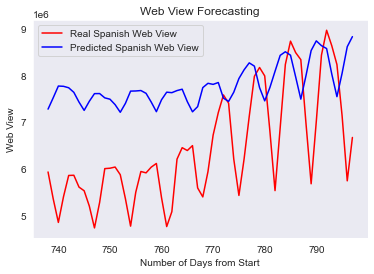

In [39]:
#Visualising Result
plt.figure
plt.plot(df_t.y, color = 'red', label = 'Real Spanish Web View')
plt.plot(df_t.pred, color = 'blue', label = 'Predicted Spanish Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()

#### 3.2.1 simple LSTM Evaluation

In [43]:
from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import mean_absolute_error #MAE
from sktime.performance_metrics.forecasting import smape_loss #sMAPE
import numpy as np

def mape(y_test, y_pred):
    return np.mean(np.abs((y_pred - y_test) / y_test)) * 100

y_Test = df_t['y']
y_Pred = df_t['pred']

MSE = mean_squared_error(y_Test,y_Pred)
MAE = mean_absolute_error(y_Test,y_Pred)
MAPE = mape(y_Test, y_Pred)
SMAPE = smape_loss(y_Test, y_Pred)

print('\nvalue of MAE: ', MAE)
print('\nvalue of MSE: ', MSE)
print('\nvalue of MAPE: ', MAPE)
print('\nvalue of sMAPE: ', SMAPE)


value of MAE:  1513481.7

value of MSE:  2959490893787.0083

value of MAPE:  26.248378322623832

value of sMAPE:  0.22293608241715482


#### 3.2.2 RNN model by grid search

In [64]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-2):
    model = keras.models.Sequential()
    model.add(LSTM(units = 8, activation = 'relu', input_shape = (None, 1)))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=["accuracy"])
    return model

In [65]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [66]:
param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=80,
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/80
16/16 [==============================] - 4s 5ms/step - loss: 0.1592 - accuracy: 2.3912e-04
Epoch 2/80
16/16 [==============================] - 0s 5ms/step - loss: 0.1004 - accuracy: 0.0045
Epoch 3/80
16/16 [==============================] - 0s 6ms/step - loss: 0.0575 - accuracy: 0.0045
Epoch 4/80
16/16 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.0016
Epoch 5/80
16/16 [==============================] - 0s 4ms/step - loss: 0.0200 - accuracy: 0.0025
Epoch 6/80
16/16 [==============================] - 0s 3ms/step - loss: 0.0229 - accuracy: 0.0025
Epoch 7/80
16/16 [==============================] - 0s 3ms/step - loss: 0.0198 - accuracy: 9.5467e-04
Epoch 8/80
16/16 [==============================] - 0s 3ms/step - loss: 0.0210 - accuracy: 0.0021
Epoch 9/80
16/16 [==============================] - 0s 3ms/step - loss: 0.0215 - accuracy: 0.0063
Epoch 10/80
16/16 [==============================

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000016720598A48>,
                   param_distributions={'n_hidden': [1, 2, 3],
                                        'n_neurons': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...]},
                   verbose=2)

In [67]:
rnd_search_cv.best_params_

{'n_neurons': 71, 'n_hidden': 2}

In [68]:
model =  build_model(n_neurons=71, n_hidden = 2)
model.fit(X_train, y_train, batch_size = 10, epochs = 50)

Epoch 1/50
74/74 [==============================] - 4s 3ms/step - loss: 0.1043 - accuracy: 0.0012
Epoch 2/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0222 - accuracy: 0.0031
Epoch 3/50
74/74 [==============================] - 0s 6ms/step - loss: 0.0215 - accuracy: 5.3654e-04
Epoch 4/50
74/74 [==============================] - 0s 6ms/step - loss: 0.0206 - accuracy: 0.0035
Epoch 5/50
74/74 [==============================] - 0s 6ms/step - loss: 0.0217 - accuracy: 0.0011
Epoch 6/50
74/74 [==============================] - 0s 6ms/step - loss: 0.0218 - accuracy: 6.4656e-04
Epoch 7/50
74/74 [==============================] - 1s 7ms/step - loss: 0.0208 - accuracy: 6.4656e-04
Epoch 8/50
74/74 [==============================] - 0s 3ms/step - loss: 0.0204 - accuracy: 3.1787e-04: 0s - loss: 0.0200 - accuracy: 0.00
Epoch 9/50
74/74 [==============================] - 0s 3ms/step - loss: 0.0197 - accuracy: 2.7379e-04
Epoch 10/50
74/74 [==============================] - 0s 3ms/st

#### 3.2.2 Grid Search RNN model Prediction

In [58]:
# Getting the predicted Web View
inputs = X_test
inputs = np.reshape(inputs,(-1,1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (60, 1, 1))

In [70]:
y_pred = model.predict(inputs)
y_pred = sc.inverse_transform(y_pred)

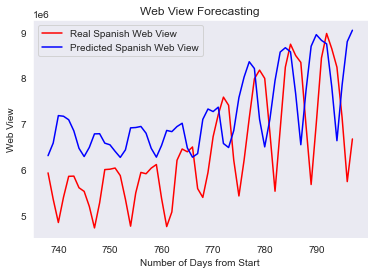

In [74]:
#Visualising Result
plt.figure
plt.plot(df_t.y, color = 'red', label = 'Real Spanish Web View')
plt.plot(df_t.pred, color = 'blue', label = 'Predicted Spanish Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()

#### 3.2.2 Grid Search RNN model Evaluation

In [72]:
df_t = y_test.copy()
df_t['pred'] = y_pred

In [73]:
from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import mean_absolute_error #MAE
from sktime.performance_metrics.forecasting import smape_loss #sMAPE
import numpy as np

def mape(y_test, y_pred):
    return np.mean(np.abs((y_pred - y_test) / y_test)) * 100

y_Test = df_t['y']
y_Pred = df_t['pred']

MSE = mean_squared_error(y_Test,y_Pred)
MAE = mean_absolute_error(y_Test,y_Pred)
MAPE = mape(y_Test, y_Pred)
SMAPE = smape_loss(y_Test, y_Pred)

print('\nvalue of MAE: ', MAE)
print('\nvalue of MSE: ', MSE)
print('\nvalue of MAPE: ', MAPE)
print('\nvalue of sMAPE: ', SMAPE)


value of MAE:  1127518.275

value of MSE:  1813117696302.546

value of MAPE:  18.955896013466976

value of sMAPE:  0.16926648704091912


## 4 Conclusion

The performance of indicators of evaluation after grid search does a better job than those of simple LSTM model, therefore, we choose the model after grid search as our final RNN model.